# Atividade Prática 02 -- Processamento Digital de Imagens
Autor: Raffael Ferreira Fernandes

Curso: Ciência da Computação - CCN

Universidade Federal do Piauí

Teresina, 2023

# **0.0) PREPARAÇÃO E IMPORTS**

In [ ]:
!pip install pillow

In [ ]:
!pip install matplotlib

In [ ]:
# Imports necessários para utilizar nas aplicações

import PIL
import pandas
import numpy as np
from PIL import Image, ImageDraw, ImageFilter, ImageChops, ImageOps
from numpy import array
import matplotlib.pyplot as plt
from skimage import morphology

# **1) OPERAÇÕES DE BORDA E NITIDEZ**

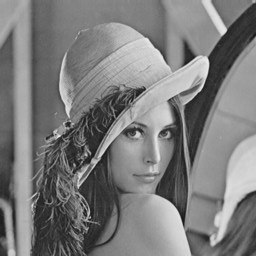

In [ ]:
im_lena = Image.open("lena_gray.bmp")
im_lena

 1.a) Filtro Laplaciano

In [ ]:
def filtro_laplaciano(imagem):
    # Obtém as dimensões da imagem
    largura, altura = imagem.size

    # Converte a imagem para uma matriz NumPy
    img_array = np.array(imagem)

    # Cria uma matriz para armazenar a imagem após o filtro Laplaciano
    resultado = np.zeros((altura, largura), dtype=np.uint8)

    # Define a máscara do filtro Laplaciano
    mascara = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    # Aplica o filtro Laplaciano pixel a pixel
    for i in range(1, altura-1):
        for j in range(1, largura-1):
            # Para aquela posição, aplica a máscara e limita os valores no intervalo possível para os valores de intensidade
            resultado[i, j] = np.clip(np.sum(img_array[i-1:i+2, j-1:j+2] * mascara), 0, 255)

    # Converte a matriz resultante de volta para uma imagem
    imagem_laplace = Image.fromarray(resultado)
    return imagem_laplace

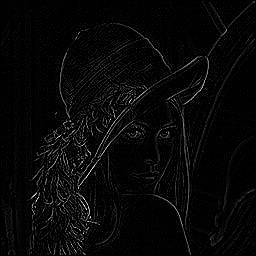

In [ ]:
lena_laplace = filtro_laplaciano(im_lena)
lena_laplace.save("lena_laplace.bmp")

lena_laplace

1.b) Unsharp masking e 1.c) Filtragem Highboost

OBS: Quando k = 1, temos a máscara de nitidez, como definido
anteriormente. Quando k > 1, o processo é chamado de
filtragem high-boost (ou filtragem “alto-reforço”). Escolher
k < 1 atenua a contribuição da máscara de nitidez.

In [ ]:
def unsharp_masking(image, k, radius):
    # Convertendo a imagem para escala de cinza
    image = image.convert('L')

    # Convertendo a imagem para matriz
    imagem = list(image.getdata())
    largura, altura = image.size
    imagem = [imagem[i * largura:(i + 1) * largura] for i in range(altura)]

    # Aplicando o filtro de desfoque gaussiano
    imagem_desfocada = image.filter(ImageFilter.GaussianBlur(radius=radius))
    imagem_desfocada = list(imagem_desfocada.getdata())
    imagem_desfocada = [imagem_desfocada[i * largura:(i + 1) * largura] for i in range(altura)]

    # Calculando a máscara
    mascara = []
    for i in range(altura):
        linha_mascara = [imagem[i][j] - imagem_desfocada[i][j] for j in range(largura)]
        mascara.append(linha_mascara)

    # Aplicando a força à máscara
    mascara = [[pixel * k for pixel in linha] for linha in mascara]

    # Calculando o resultado final
    resultado = []
    for i in range(altura):
        linha_resultado = [min(255, max(0, imagem[i][j] + mascara[i][j])) for j in range(largura)]
        resultado.append(linha_resultado)

    # Convertendo a matriz de volta para imagem
    resultado_imagem = Image.new('L', (largura, altura))
    resultado_imagem.putdata([pixel for linha in resultado for pixel in linha])

    return resultado_imagem

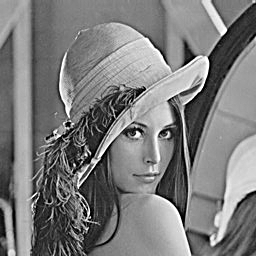

In [ ]:
# Máscara de Nitidez

lena_unsharp = unsharp_masking(im_lena, 1, 2)
lena_unsharp

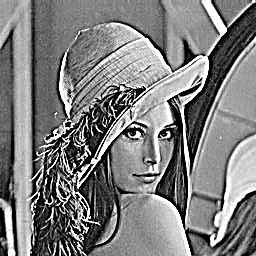

In [ ]:
# Filtragem Highboost

lena_highboost = unsharp_masking(im_lena, 5, 2)
lena_highboost

In [ ]:
# função que recebe uma imagem e uma máscara e aplica a operação de convolução

def convolucao(imagem, mascara):
    altura, largura = len(imagem), len(imagem[0])
    altura_mascara, largura_mascara = len(mascara), len(mascara[0])

    # Função para obter o valor da imagem com bordas replicadas
    def get_pixel(x, y):
        x = max(0, min(altura - 1, x))
        y = max(0, min(largura - 1, y))
        return imagem[x][y]

    resultado = [[0 for _ in range(largura)] for _ in range(altura)]

    for i in range(altura):
        for j in range(largura):
            soma = 0
            for m in range(altura_mascara):
                for n in range(largura_mascara):
                    x = i - altura_mascara // 2 + m
                    y = j - largura_mascara // 2 + n

                    valor_pixel = get_pixel(x, y)
                    soma += valor_pixel * mascara[m][n]

            resultado[i][j] = soma

    return resultado

1.d) Detecção de Bordas
i) Máscara de Prewitt

In [ ]:
# tem como função remover as bordas acrescentadas à imagem original, no momento
# da aplicação da máscara

def cortar_bordas(imagem, borda):
    altura, largura = len(imagem), len(imagem[0])
    return [linha[borda:largura - borda] for linha in imagem[borda:altura - borda]]

In [ ]:
def prewitt_mask(image):
    # Convertendo a imagem para escala de cinza
    image = image.convert('L')

    # Convertendo a imagem para matriz
    imagem = list(image.getdata())
    largura, altura = image.size
    imagem = [imagem[i * largura:(i + 1) * largura] for i in range(altura)]

    # Definindo as máscaras de Prewitt
    mascara_x = [[-1, 0, 1] for _ in range(3)]
    mascara_y = [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]

    # Aplicando as máscaras de Prewitt
    gradiente_x = convolucao(imagem, mascara_x)
    gradiente_y = convolucao(imagem, mascara_y)

    # Calculando o módulo do gradiente
    modulo_gradiente = [[((gradiente_x[i][j]**2) + (gradiente_y[i][j]**2))**0.5 for j in range(largura)] for i in range(altura)]

    # Normalizando os valores para o intervalo [0, 255]
    modulo_gradiente = [[min(255, max(0, int(valor))) for valor in linha] for linha in modulo_gradiente]

    # Cortando as bordas
    borda = 1
    modulo_gradiente_cortado = cortar_bordas(modulo_gradiente, borda)

    # Convertendo a matriz de volta para imagem
    resultado_imagem = Image.new('L', (largura - 2 * borda, altura - 2 * borda))
    resultado_imagem.putdata([pixel for linha in modulo_gradiente_cortado for pixel in linha])

    return resultado_imagem

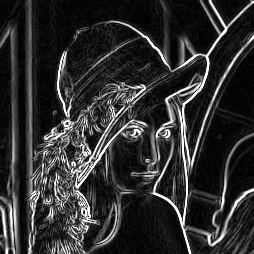

In [ ]:
lena_prewitt = prewitt_mask(im_lena)
lena_prewitt

ii) Máscara de Sobel

In [ ]:
# Máscara de Sobel

def sobel_mask(image):
    # Convertendo a imagem para escala de cinza
    image = image.convert('L')

    # Convertendo a imagem para matriz
    imagem = list(image.getdata())
    largura, altura = image.size
    imagem = [imagem[i * largura:(i + 1) * largura] for i in range(altura)]

    # Definindo as máscaras de Sobel
    mascara_x = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    mascara_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

    # Aplicando as máscaras de Sobel
    gradiente_x = convolucao(imagem, mascara_x)
    gradiente_y = convolucao(imagem, mascara_y)

    # Calculando o módulo do gradiente
    modulo_gradiente = [[((gradiente_x[i][j]**2) + (gradiente_y[i][j]**2))**0.5 for j in range(largura)] for i in range(altura)]

    # Normalizando os valores para o intervalo [0, 255]
    modulo_gradiente = [[min(255, max(0, int(valor))) for valor in linha] for linha in modulo_gradiente]

    # Cortando as bordas
    borda = 1
    modulo_gradiente_cortado = cortar_bordas(modulo_gradiente, borda)

    # Convertendo a matriz de volta para imagem
    resultado_imagem = Image.new('L', (largura - 2 * borda, altura - 2 * borda))
    resultado_imagem.putdata([pixel for linha in modulo_gradiente_cortado for pixel in linha])

    return resultado_imagem


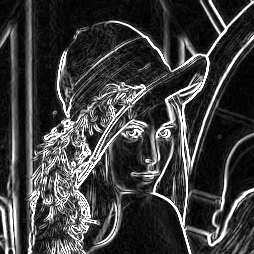

In [ ]:
lena_sobel = sobel_mask(im_lena)
lena_sobel

# **2. APLICAÇÃO DE FILTROS**

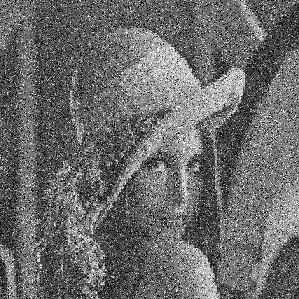

In [ ]:
lena_r = Image.open("lena_ruido.bmp")
lena_r

i) Filtro da Mediana

In [ ]:
def filtro_mediana(imagem, tamanho_vizinhanca=3):
    # Convertendo a imagem para escala de cinza
    imagem = imagem.convert('L')

    # Convertendo a imagem para matriz
    img = list(imagem.getdata())
    largura, altura = imagem.size
    img = [img[i * largura:(i + 1) * largura] for i in range(altura)]

    # Aplicando o filtro da mediana
    resultado = []
    for i in range(altura):
        linha_resultado = []
        for j in range(largura):
            vizinhanca = []

            # Coletando os valores da vizinhança
            for m in range(-tamanho_vizinhanca // 2, tamanho_vizinhanca // 2 + 1):
                for n in range(-tamanho_vizinhanca // 2, tamanho_vizinhanca // 2 + 1):
                    x = i + m
                    y = j + n

                    # Certificando-se de não ultrapassar os limites da imagem
                    x = max(0, min(altura - 1, x))
                    y = max(0, min(largura - 1, y))

                    vizinhanca.append(img[x][y])

            # Substituindo o pixel pela mediana da vizinhança
            linha_resultado.append(sorted(vizinhanca)[len(vizinhanca) // 2])

        resultado.append(linha_resultado)

    # Convertendo a matriz de volta para imagem
    imagem_resultante = Image.new('L', (largura, altura))
    imagem_resultante.putdata([pixel for linha in resultado for pixel in linha])

    return imagem_resultante

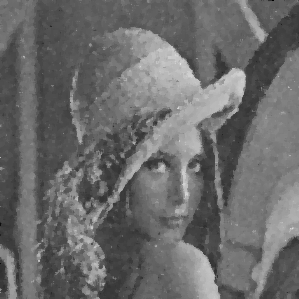

In [ ]:
lena_mediana = filtro_mediana(lena_r, 3)
lena_mediana

Função genérica para aplicação de máscara a uma figura pela operação de convolução

In [ ]:
def aplicar_mascara(imagem, mascara):
    # Convertendo a imagem para escala de cinza
    imagem = imagem.convert('L')

    # Convertendo a imagem para matriz
    img = list(imagem.getdata())
    largura, altura = imagem.size
    img = [img[i * largura:(i + 1) * largura] for i in range(altura)]

    # Aplicando a máscara
    resultado = convolucao(img, mascara)

    # Convertendo a matriz de volta para imagem
    imagem_resultante = Image.new('L', (largura, altura))
    imagem_resultante.putdata([pixel for linha in resultado for pixel in linha])

    return imagem_resultante

ii) Máscara 01

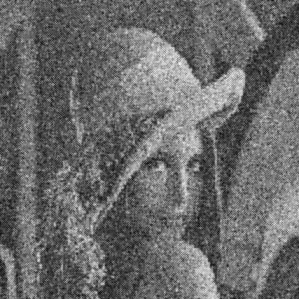

In [ ]:
masc_1 = [[0, 1/5, 0],
          [1/5, 1/5, 1/5],
          [0, 1/5, 0]]
lena_masc_1 = aplicar_mascara(lena_r, masc_1)
lena_masc_1

iii) Máscara 02

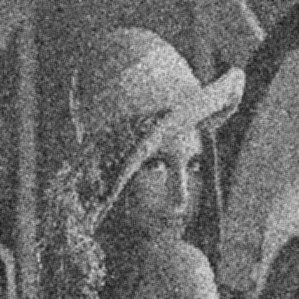

In [ ]:
masc_2 = [[1/9, 1/9, 1/9],
          [1/9, 1/9, 1/9],
          [1/9, 1/9, 1/9]]
lena_masc_2 = aplicar_mascara(lena_r, masc_2)
lena_masc_2

iv) Máscara 03

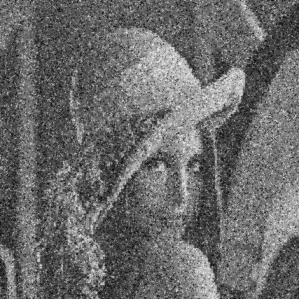

In [ ]:
masc_3 = [[1/32, 3/32, 1/32],
          [3/32, 1/2, 3/32],
          [1/32, 3/32, 1/32]]
lena_masc_3 = aplicar_mascara(lena_r, masc_3)
lena_masc_3

v) Máscara 04

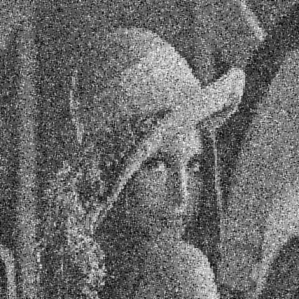

In [ ]:
masc_4 = [[0, 1/8, 0],
          [1/8, 1/2, 1/8],
          [0, 1/8, 0]]
lena_masc_4 = aplicar_mascara(lena_r, masc_4)
lena_masc_4

# **3) OPERAÇÕES MORFOLÓGICAS (PT.1)**

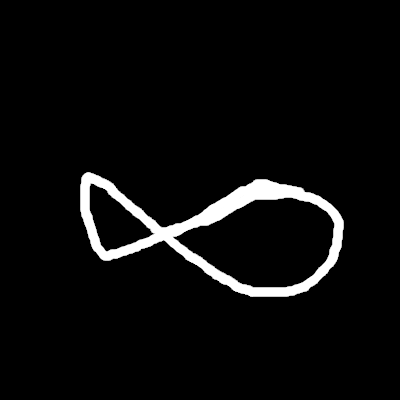

In [ ]:
imagem1 = Image.open("imagem1.bmp")
imagem1

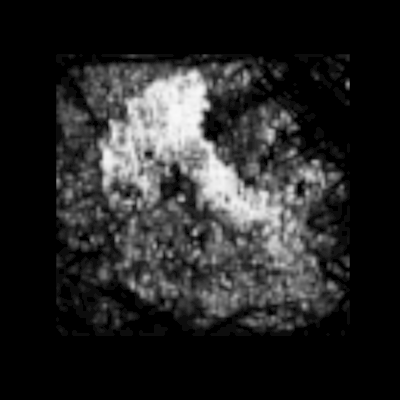

In [ ]:
imagem2 = Image.open("imagem2.bmp")
imagem2

In [ ]:
def op_morfologica(imagem1, imagem2, tipo_operacao):
    # Convertendo as imagens para matrizes
    matriz1 = np.array(imagem1)
    matriz2 = np.array(imagem2)

    # Verificando se as imagens têm o mesmo formato
    if matriz1.shape != matriz2.shape:
        raise ValueError("As imagens devem ter o mesmo formato para operações morfológicas.")

    # Aplicando as operações morfológicas
    if tipo_operacao == 0:  # União
        resultado = np.maximum(matriz1, matriz2)
    elif tipo_operacao == 1:  # Interseção
        resultado = np.minimum(matriz1, matriz2)
    elif tipo_operacao == 2:  # Diferença
        #obtém as dimensões das imagens

        imagem1 = imagem1.convert('L')
        imagem2 = imagem2.convert('L')

        matriz1 = np.array(imagem1)
        matriz2 = np.array(imagem2)

        altura, largura = matriz1.shape

        #cria uma matriz para armazenar o resultado da operação morfológica
        resultado = np.zeros((altura, largura), dtype=np.uint8)

        #itera sobre cada pixel
        for i in range(altura):
            for j in range(largura):
                #define o valor do pixel resultante como a diferença entre os valores das duas imagens
                resultado[i, j] = max(int(matriz1[i, j]) - int(matriz2[i, j]), 0)
    else:
        raise ValueError("Tipo de operação morfológica inválido. Use 0 para união, 1 para interseção ou 2 para diferença.")

    # Convertendo a matriz de volta para imagem
    imagem_resultante = Image.fromarray(resultado.astype(np.uint8))

    return imagem_resultante


**3. a) União**

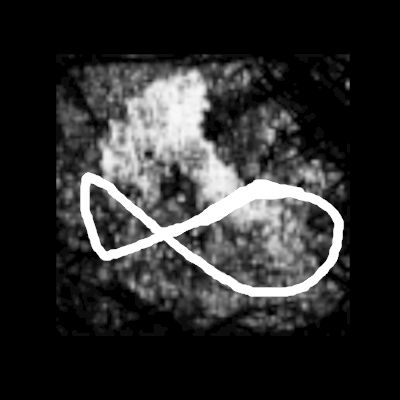

In [ ]:
im_uniao = op_morfologica(imagem1, imagem2, 0)
im_uniao

**3. b) Intersecção**

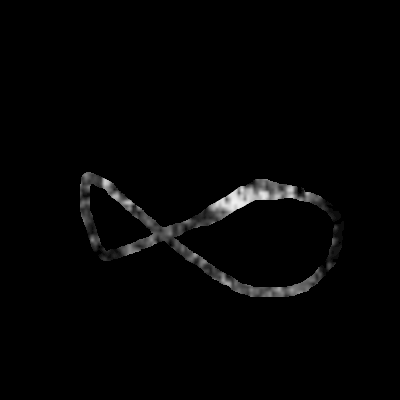

In [ ]:
im_inters = op_morfologica(imagem1, imagem2, 1)
im_inters

**3. c) Diferença (imagem1 - imagem2)**

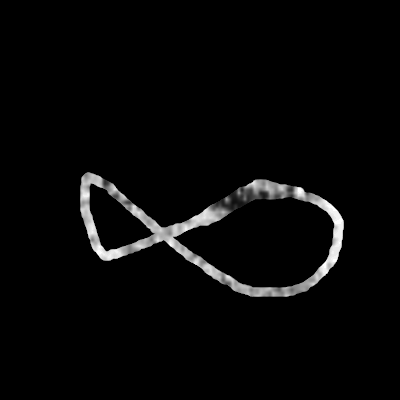

In [ ]:
im_dif1 = op_morfologica(imagem1, imagem2, 2)
im_dif1

**3. c) Diferença (imagem2 - imagem1)**

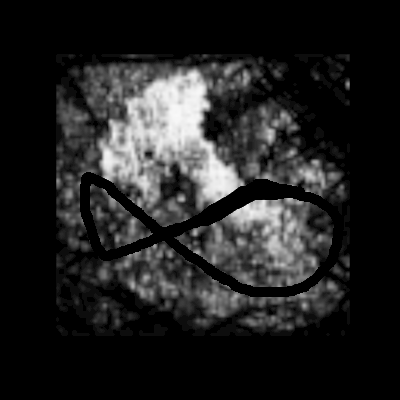

In [ ]:
im_dif2 = op_morfologica(imagem2, imagem1, 2)
im_dif2

# **4) OPERAÇÕES MORFOLÓGICAS (PT. 2)**

In [ ]:
def erosao(imagem, elemento_estruturante, centro):
    # Convertendo a imagem para escala de cinza
    imagem = imagem.convert('L')

    # Convertendo a imagem para matriz binária (0 para preto, 1 para branco)
    matriz_binaria = np.array(imagem) > 128

    # Obtendo as dimensões da imagem e do elemento estruturante
    altura, largura = matriz_binaria.shape
    tamanho_elemento_estruturante = elemento_estruturante.shape
    altura_elemento, largura_elemento = tamanho_elemento_estruturante

    # Criando uma matriz para armazenar o resultado da erosão
    resultado_erosao = np.zeros((altura, largura), dtype=np.uint8)

    # Iterando sobre cada pixel da imagem
    for i in range(altura):
        for j in range(largura):
            # Inicializando a flag como True (indicando que o pixel atende às condições)
            atende_condicoes = True

            # Verificando se o elemento estruturante se encaixa nos pixels vizinhos do pixel central
            for m in range(altura_elemento):
                for n in range(largura_elemento):
                    # Coordenadas no elemento estruturante
                    x_elem = m - centro[0]
                    y_elem = n - centro[1]

                    # Coordenadas na imagem
                    x_imagem = i + x_elem
                    y_imagem = j + y_elem

                    # Verificando se as coordenadas estão dentro dos limites da imagem
                    if x_imagem < 0 or x_imagem >= altura or y_imagem < 0 or y_imagem >= largura:
                        atende_condicoes = False
                        break

                    # Verificando se o pixel na imagem é 1 e corresponde ao elemento estruturante
                    if elemento_estruturante[m, n] == 1 and matriz_binaria[x_imagem, y_imagem] != 1:
                        atende_condicoes = False
                        break

            # Marcando o pixel central na imagem resultante
            resultado_erosao[i, j] = 1 if atende_condicoes else 0

    # Convertendo a matriz de volta para imagem binária
    imagem_resultante = Image.fromarray((resultado_erosao * 255).astype(np.uint8))

    return imagem_resultante

In [ ]:
def dilatacao(imagem, elemento_estruturante, centro):
    # Convertendo a imagem para escala de cinza
    imagem = imagem.convert('L')

    # Convertendo a imagem para matriz binária (0 para preto, 1 para branco)
    matriz_binaria = np.array(imagem) > 128

    # Obtendo as dimensões da imagem e do elemento estruturante
    altura, largura = matriz_binaria.shape
    tamanho_elemento_estruturante = len(elemento_estruturante)

    # Criando uma matriz para armazenar o resultado da dilatação
    resultado_dilatacao = np.zeros((altura, largura), dtype=np.uint8)

    # Iterando sobre cada pixel da imagem
    for i in range(altura):
        for j in range(largura):
            # Verificando se o pixel na imagem é branco
            if matriz_binaria[i, j] == 1:
                # Aplicando o elemento estruturante na vizinhança do pixel
                for m in range(tamanho_elemento_estruturante):
                    for n in range(tamanho_elemento_estruturante):
                        # Coordenadas no elemento estruturante
                        x_elem = m - centro[0]
                        y_elem = n - centro[1]

                        # Coordenadas na imagem
                        x_imagem = i + x_elem
                        y_imagem = j + y_elem

                        # Verificando se as coordenadas estão dentro dos limites da imagem
                        if x_imagem >= 0 and x_imagem < altura and y_imagem >= 0 and y_imagem < largura:
                            resultado_dilatacao[x_imagem, y_imagem] = 1

    # Convertendo a matriz de volta para imagem
    imagem_resultante = Image.fromarray((resultado_dilatacao * 255).astype(np.uint8))

    return imagem_resultante

In [ ]:
def abertura(imagem, elemento_estruturante, centro):
    # Aplicando erosão seguida de dilatação (abertura)
    imagem_erosao = erosao(imagem, elemento_estruturante, centro)
    imagem_abertura = dilatacao(imagem_erosao, elemento_estruturante, centro)

    return imagem_abertura

def fechamento(imagem, elemento_estruturante, centro):
    # Aplicando dilatação seguida de erosão (fechamento)
    imagem_dilatacao = dilatacao(imagem, elemento_estruturante, centro)
    imagem_fechamento = erosao(imagem_dilatacao, elemento_estruturante, centro)

    return imagem_fechamento

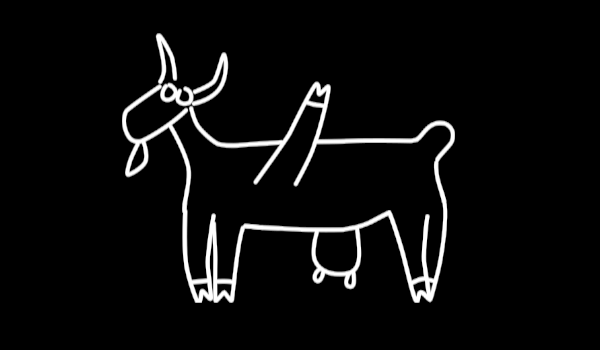

In [ ]:
animal = Image.open("animal.bmp")
animal

In [ ]:
elemento_estruturante = np.array([[0, 1, 0],
                                   [1, 1, 1],
                                   [0, 1, 0]])
centro = (1, 1)

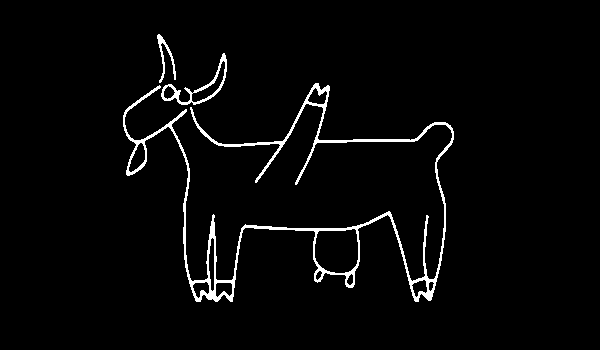

In [ ]:
erosao(animal, elemento_estruturante, centro)

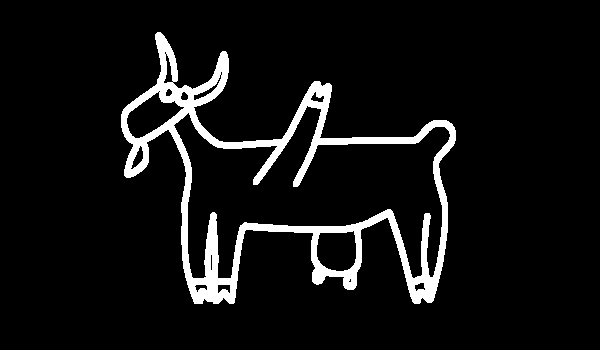

In [ ]:
dilatacao(animal, elemento_estruturante, centro)

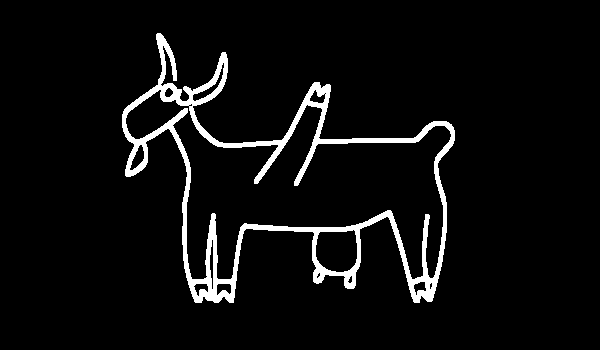

In [ ]:
abertura(animal, elemento_estruturante, centro)

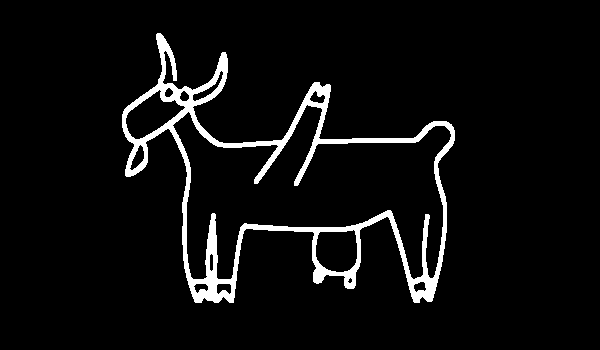

In [ ]:
fechamento(animal, elemento_estruturante, centro)

# **5) OPERAÇÕES MORFOLÓGICAS (PT. 3)**

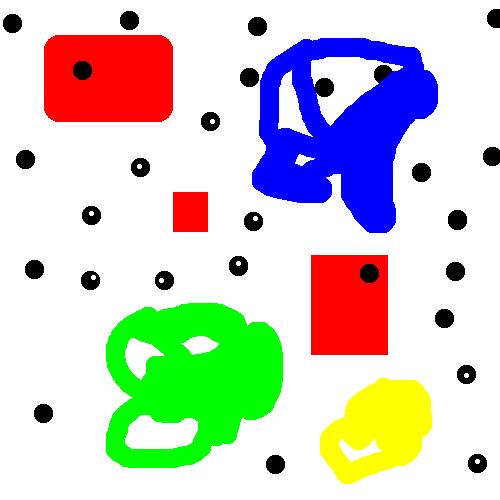

In [ ]:
quadro = Image.open("quadro.png")
quadro

# **5. A) PREENCHIMENTO DE BURACO DE OBJETOS PRETOS**

In [ ]:
# função para extrair objetos pretos da figura
def extracao(imagem, cor):

  largura, altura = imagem.size

  resultado = Image.new(imagem.mode, (largura, altura), (255, 255, 255, 255))

  for x in range(largura):
    for y in range(altura):
      pixel = imagem.getpixel((x,y))

      if pixel == cor:
        resultado.putpixel((x,y),pixel)

  return resultado

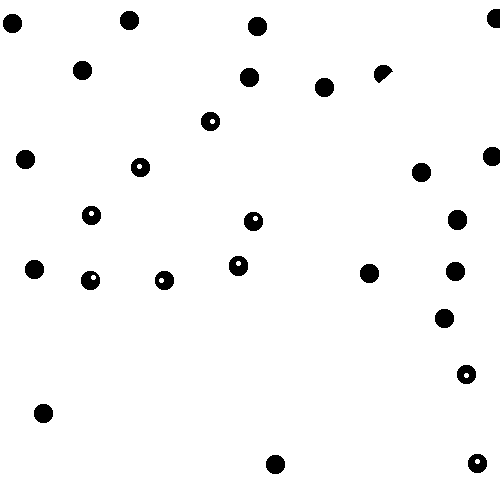

In [ ]:
preto = (0, 0, 0, 255)
quadro_pretos = extracao(quadro, preto)
quadro_pretos

In [ ]:
def flood_fill(imagem, ponto_inicio, novo_valor):
    pilha = [ponto_inicio]

    valor_original = imagem.getpixel(ponto_inicio)

    while pilha:
        x, y = pilha.pop()

        if imagem.getpixel((x, y)) == valor_original:
            imagem.putpixel((x, y), novo_valor)

            # Adiciona vizinhos à pilha
            if x > 0:
                pilha.append((x - 1, y))
            if x < imagem.width - 1:
                pilha.append((x + 1, y))
            if y > 0:
                pilha.append((x, y - 1))
            if y < imagem.height - 1:
                pilha.append((x, y + 1))

In [ ]:
def extrai_buracos(imagem, cor_objeto=None):
    # Verifica se a imagem é RGB ou escala de cinza
    if imagem.mode == 'RGB':
        return extrai_buracos_rgb(imagem, cor_objeto)
    elif imagem.mode == 'L':
        return extrai_buracos_escala_de_cinza(imagem)
    else:
        raise ValueError("Tipo de imagem não suportado. Use 'RGB' ou 'L'.")

def extrai_buracos_rgb(imagem, cor_objeto=None):
    largura, altura = imagem.size

    # Cria uma cópia da imagem
    imagem_processada = imagem.copy()

    # Pintando o fundo
    flood_fill(imagem_processada, (0, 0), (cor_objeto))
    flood_fill(imagem_processada, (0, 0), (0, 0, 0))

    return imagem_processada




def extrai_buracos_escala_de_cinza(imagem):
    largura, altura = imagem.size

    # Cria uma cópia da imagem
    imagem_processada = imagem.copy()

    # Obtendo os valores RGB da cor do objeto, se fornecida
    cor_objeto = None

    # Pintando o fundo
    flood_fill(imagem_processada, (0, 0), 100)
    flood_fill(imagem_processada, (0, 0), 0)

    return imagem_processada

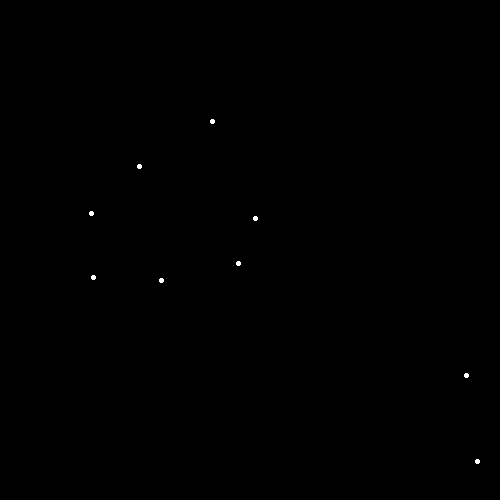

In [ ]:
buracos = extrai_buracos(quadro_pretos.convert('L'), _)
buracos

In [ ]:
def negativa(imagem):
  largura, altura = imagem.size
  nova_im = Image.new("L", (largura, altura), "black")

  for i in range(largura):
    for j in range(altura):
      cor = 255 - imagem.getpixel((i, j))
      nova_im.putpixel((i, j), cor)

  return nova_im

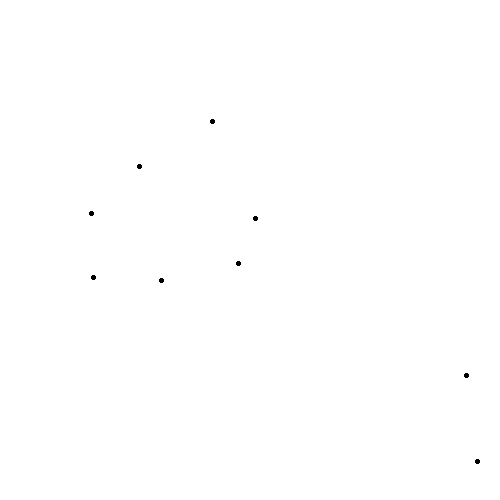

In [ ]:
masc_pretos = negativa(buracos)
masc_pretos

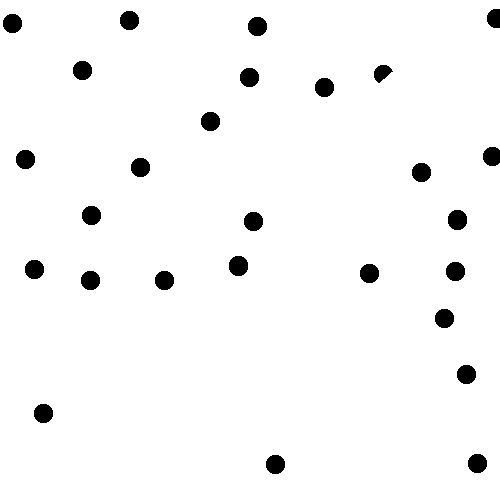

In [ ]:
pretos_preenchidos = op_morfologica(quadro_pretos.convert('L'), masc_pretos, 1)
pretos_preenchidos

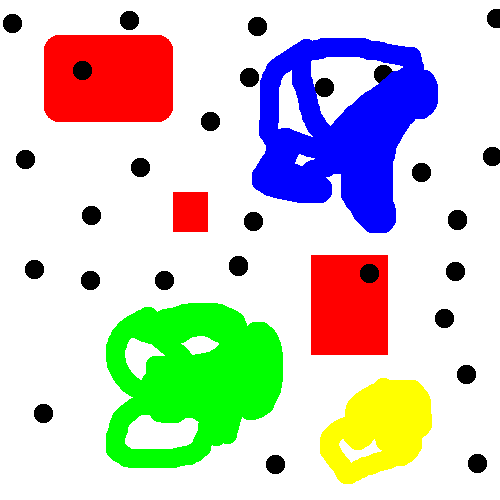

In [ ]:
def preenche_pretos(imagem1, imagem2):
    largura, altura = imagem1.size

    image = imagem1.copy()
    image = image.convert('RGB')
    imagem2 = imagem2.convert('L')

    for i in range(altura):
        for j in range(largura):
            if (imagem2.getpixel((j, i)) == 0):
                image.putpixel((j, i), (0, 0, 0))

    return image

quadro_pretos_preenc = preenche_pretos(quadro, pretos_preenchidos)
quadro_pretos_preenc

# **5. B) ELIMINANDO OBJETOS PRETOS**

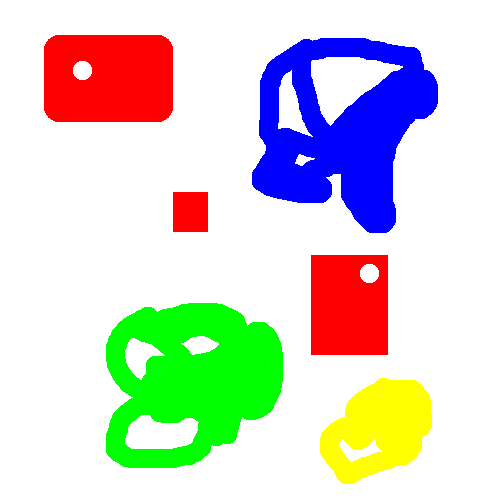

In [ ]:
def remove_pretos(imagem1, imagem2):
  imagem1 = imagem1.convert('RGB')
  imagem2 = negativa(imagem2)
  imagem2 = imagem2.convert('RGB')
  return op_morfologica(imagem1, imagem2, 0)

quadro_sem_pretos = remove_pretos(quadro, pretos_preenchidos)
quadro_sem_pretos

# **5. C) PREENCHIMENTO DE BURACO DOS OBJETOS COLORIDOS**

In [ ]:
def preenche_buracos(imagem1, imagem2, cor):
    largura, altura = imagem1.size

    image = imagem1.copy()
    image = image.convert('RGB')
    imagem2 = imagem2.convert('L')

    for i in range(altura):
        for j in range(largura):
            if (imagem2.getpixel((j, i)) == 255):
                image.putpixel((j, i), cor)

    return image

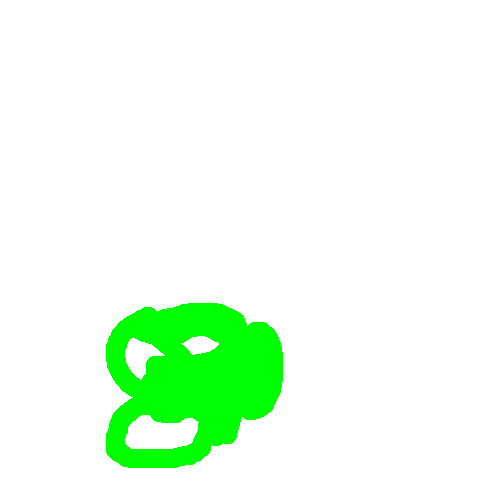

In [ ]:
quadro_verde = extracao(quadro, (0, 255, 0, 255))
quadro_verde

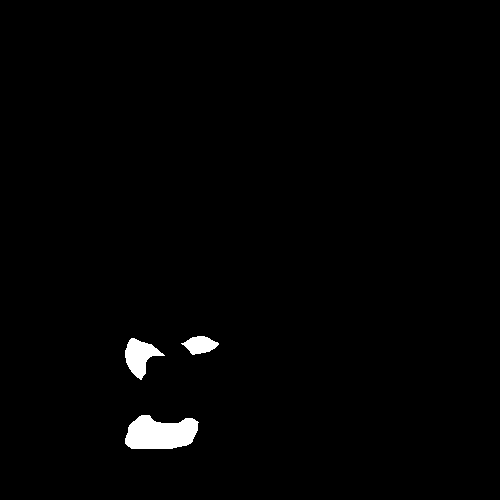

In [ ]:
verde = (0, 255, 0)
buracos_verde = extrai_buracos(quadro_verde.convert('RGB'), verde)
buracos_verde

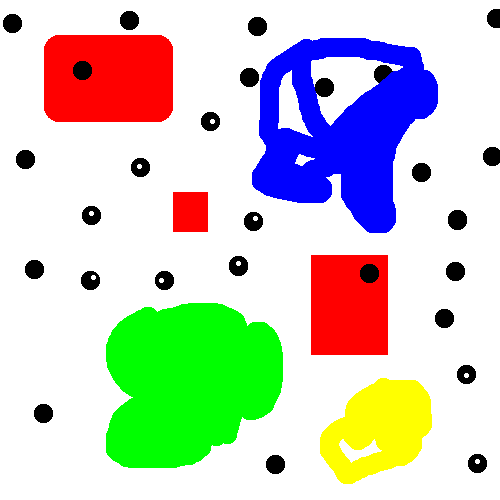

In [ ]:
quadro_verde_preenc = preenche_buracos(quadro, buracos_verde, verde)
quadro_verde_preenc

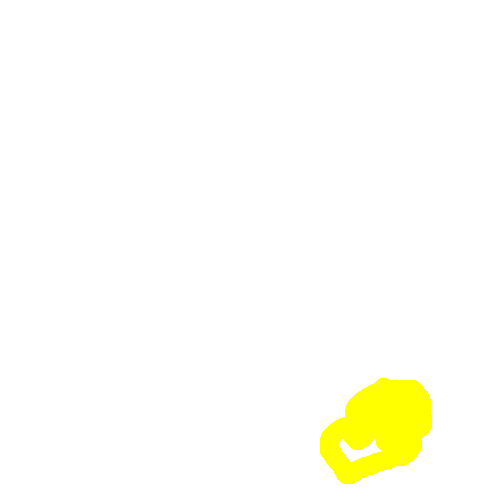

In [ ]:
quadro_amarelo = extracao(quadro, (255, 255, 0, 255))
quadro_amarelo

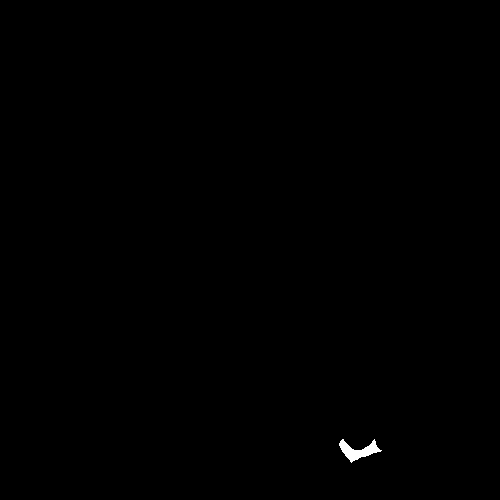

In [ ]:
amarelo = (255, 255, 0)
buracos_amarelo = extrai_buracos(quadro_amarelo.convert('RGB'), amarelo)
buracos_amarelo

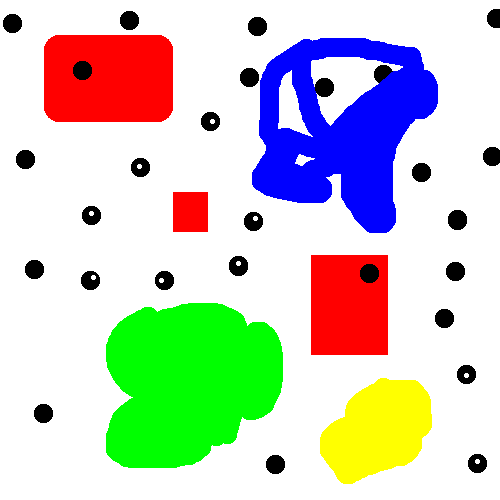

In [ ]:
quadro_amarelo_preenc = preenche_buracos(quadro_verde_preenc, buracos_amarelo, amarelo)
quadro_amarelo_preenc

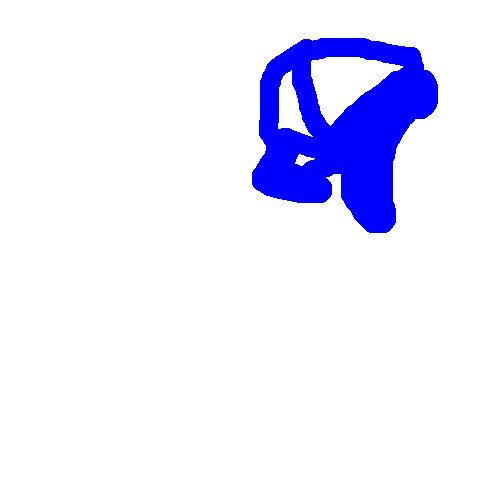

In [ ]:
quadro_azul = extracao(quadro, (0, 0, 255, 255))
quadro_azul

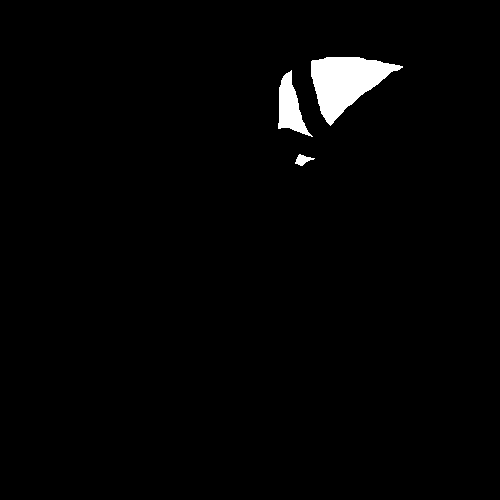

In [ ]:
azul = (0, 0, 255)
buracos_azul = extrai_buracos(quadro_azul.convert('RGB'), azul)
buracos_azul

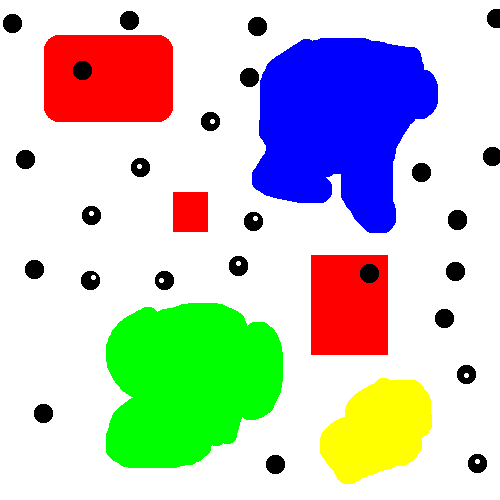

In [ ]:
quadro_azul_preenc = preenche_buracos(quadro_amarelo_preenc, buracos_azul, azul)
quadro_azul_preenc

# **5. D) FECHO CONVEXO**

In [ ]:
def encontrar_limites(imagem, cor):
    largura, altura = imagem.size

    limite_esquerdo = largura
    limite_superior = altura
    limite_direito = 0
    limite_inferior = 0

    for i in range(largura):
        for j in range(altura):
            if imagem.getpixel((i, j)) == cor:
                limite_esquerdo = min(limite_esquerdo, i)
                limite_superior = min(limite_superior, j)
                limite_direito = max(limite_direito, i)
                limite_inferior = max(limite_inferior, j)

    return limite_esquerdo, limite_superior, limite_direito, limite_inferior

In [ ]:
def aplica_el_estrt(imagem, elemento, cor):
    nova_im = imagem.copy()
    larg, alt = imagem.size

    for j in range(1, alt-1):
        for i in range(1, larg-1):
            hit_or_miss = True
            vizinhos = [
                [(i-1, j-1), (i, j-1), (i+1, j-1)],
                [(i-1, j), (i, j), (i+1, j)],
                [(i-1, j+1), (i, j+1), (i+1, j+1)]
            ]
            for a in range(3):
                for b in range(3):
                    if (elemento[a][b] == 1) and (nova_im.getpixel(vizinhos[a][b]) != cor):
                        hit_or_miss = False
                    if (elemento[a][b] == 0) and (nova_im.getpixel(vizinhos[a][b]) == cor):
                        hit_or_miss = False
            if hit_or_miss:
                nova_im.putpixel((i, j), cor)

    return nova_im

In [ ]:
def fecho_convexo(imagem, cor):
    largura, altura = imagem.size
    imagem_com_bordas = ImageOps.expand(imagem, border=1, fill='white')

    elementos_estruturantes = [
        [(1, -1, -1), (1, 0, -1), (1, -1, -1)],
        [(1, 1, 1), (-1, 0, -1), (-1, -1, -1)],
        [(-1, -1, 1), (-1, 0, 1), (-1, -1, 1)],
        [(-1, -1, -1), (-1, 0, -1), (1, 1, 1)]
    ]

    imagens_finais = []

    for elemento in elementos_estruturantes:
        atual_it = Image.new("RGB", (largura+2, altura+2), "white")
        prox_it = imagem_com_bordas

        while len(set(ImageChops.difference(atual_it, prox_it).getdata())) > 1:
            atual_it = prox_it
            prox_it = aplica_el_estrt(atual_it, elemento, cor)

        imagens_finais.append(prox_it)

    imagem_final = Image.new("RGB", (largura+2, altura+2), "white")

    limite_esquerdo, limite_superior, limite_direito, limite_inferior = encontrar_limites(imagem, cor)

    for im in imagens_finais:
        for i in range(limite_esquerdo, limite_direito):
            for j in range(limite_superior, limite_inferior):
                if im.getpixel((i, j)) == cor:
                    imagem_final.putpixel((i, j), cor)

    imagem_final = imagem_final.crop((1, 1, largura, altura))

    return imagem_final


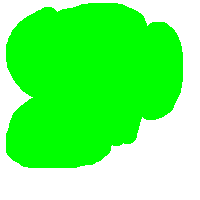

In [ ]:
apenas_quadro_verde = preenche_buracos(quadro_verde, buracos_verde, verde)
apenas_quadro_verde = apenas_quadro_verde.crop((100, 300, 300, 500))
apenas_quadro_verde

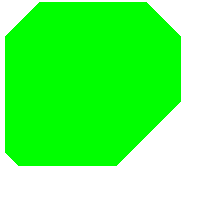

In [ ]:
verde_fecho = fecho_convexo(apenas_quadro_verde.convert('RGB'), verde)
verde_fecho

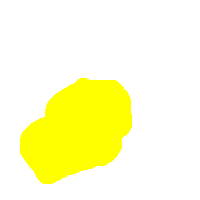

In [ ]:
apenas_quadro_amarelo = preenche_buracos(quadro_amarelo, buracos_amarelo, amarelo)
apenas_quadro_amarelo = apenas_quadro_amarelo.crop((300, 300, 500, 500))
apenas_quadro_amarelo

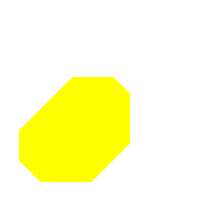

In [ ]:
amarelo_fecho = fecho_convexo(apenas_quadro_amarelo.convert('RGB'), amarelo)
amarelo_fecho

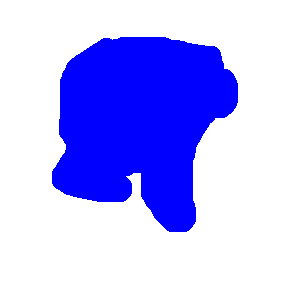

In [ ]:
apenas_quadro_azul = preenche_buracos(quadro_azul, buracos_azul, azul)
apenas_quadro_azul = apenas_quadro_azul.crop((200, 1, 500, 300))
apenas_quadro_azul

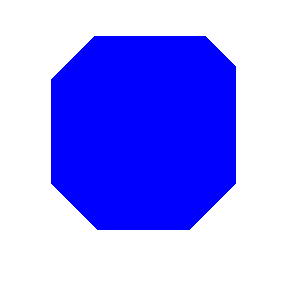

In [ ]:
azul_fecho = fecho_convexo(apenas_quadro_azul.convert('RGB'), azul)
azul_fecho

# **5. E) ESQUELETO**

In [ ]:
elemento_B = np.array([[1, 1, 1],
                                   [1, 1, 1],
                                   [1, 1, 1]])
centro = (1, 1)

In [ ]:
def esqueleto(imagem, cor):
  imagem_cinza = imagem.convert('L')
  imagem_binarizada = imagem_cinza.point(lambda pixel: 0 if pixel > 250 else 1, '1')

  imagens = []

  k = 1
  referencia = Image.new("L", imagem.size, "black")
  prox_erosao = erosao(imagem_binarizada, elemento_B, centro)

  erosoes = [imagem_binarizada, prox_erosao]
  # descobrir o valor de k
  while(len(set(ImageChops.difference(referencia, prox_erosao).getdata())) > 1):
    prox_erosao = erosao(prox_erosao, elemento_B, centro)
    erosoes.append(prox_erosao)
    k+=1
  k-=1
  del(erosoes[-1])

  for i in range(k):
    Sa = erosoes[i]
    Sb = abertura(Sa, elemento_B, centro)
    Sc = op_morfologica(Sa, Sb, 2)
    imagens.append(Sc)

  imagem_final = imagens[0]
  for i in range(1, len(imagens)):
    imagem_final = op_morfologica(imagem_final, imagens[i], 0)

  return imagem_final


  # Retornando o esqueleto colorido (descomentar caso não queira o esqueleto em preto e branco)
  #largura, altura = imagem.size
  #esqueleto = Image.new('RGB', (largura, altura), 'white')
  #for j in range(altura):
  #  for i in range(largura):
  #    if imagem_final.getpixel((i, j)) == 255:
  #      esqueleto.putpixel((i, j), cor)
  #
  #return esqueleto

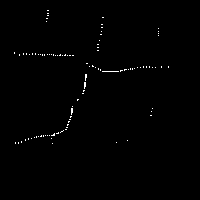

In [ ]:
esqueleto_verde = esqueleto(apenas_quadro_verde, verde)
esqueleto_verde

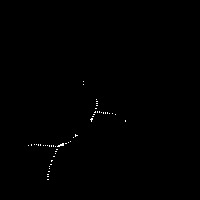

In [ ]:
esqueleto_amarelo = esqueleto(apenas_quadro_amarelo, amarelo)
esqueleto_amarelo

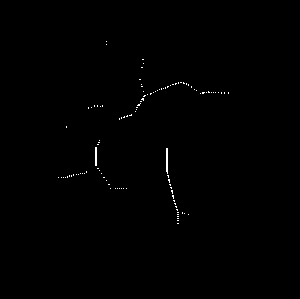

In [ ]:
esqueleto_azul = esqueleto(apenas_quadro_azul, azul)
esqueleto_azul

# **5. F) TRANSFORMADA HIT-OR-MISS**

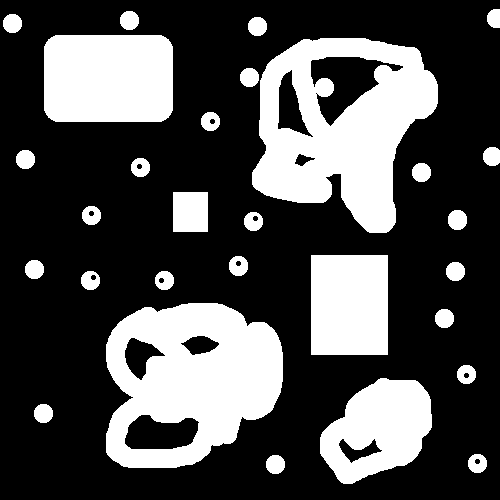

In [ ]:
quadro_pb = quadro.convert('L')
quadro_pb = quadro_pb.point(lambda pixel: 0 if pixel > 250 else 1, '1')
quadro_pb

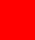

In [ ]:
item_vermelho_1 = quadro.crop((173, 192, 208, 232))
item_vermelho_1

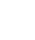

In [ ]:
item_vermelho_1 = quadro_pb.crop((173, 192, 208, 232))
item_vermelho_1

In [ ]:
matriz_s1 = np.array(item_vermelho_1)
print(matriz_s1.shape)

(40, 35)


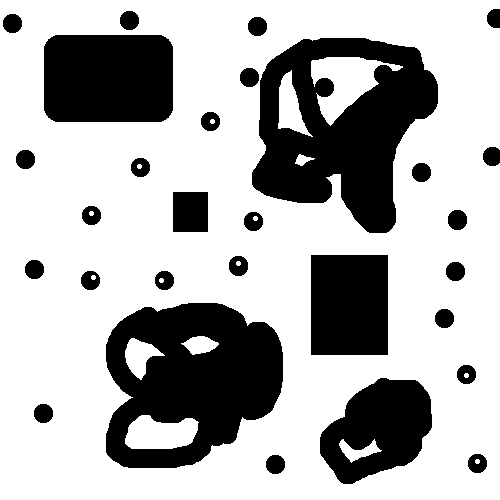

In [ ]:
quadro_pb_comp = quadro_pb.point(lambda pixel: 0 if pixel > 0 else 1, '1')
quadro_pb_comp

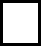

In [ ]:
w1_menos_itemverm1 = quadro_pb.crop((170, 189, 211, 235))
w1_menos_itemverm1

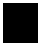

In [ ]:
w2_menos_itemverm1 = w1_menos_itemverm1.point(lambda pixel: 0 if pixel > 0 else 1, '1')
w2_menos_itemverm1

In [ ]:
matriz_ws1 = np.array(w2_menos_itemverm1)
print(matriz_ws1.shape)

(46, 41)


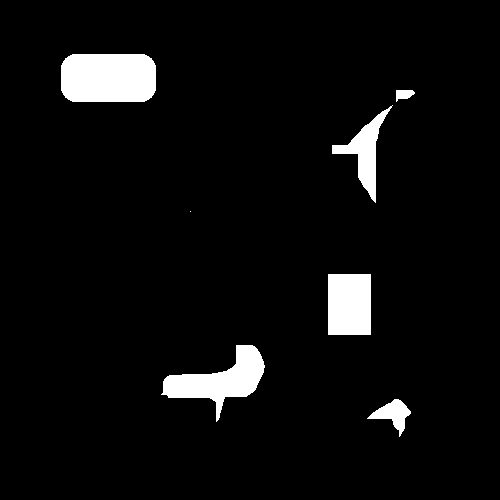

In [ ]:
quadro_erosao_s = morphology.erosion(quadro_pb, matriz_s1)
quadro_erosao_s = Image.fromarray(quadro_erosao_s)
quadro_erosao_s

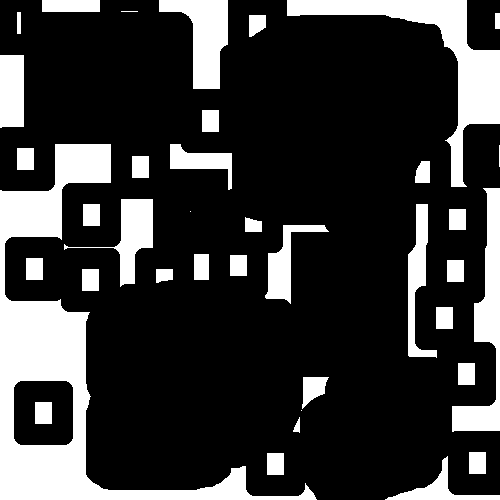

In [ ]:
quadro_erosao_ws = morphology.erosion(quadro_pb_comp, matriz_ws1)
quadro_erosao_ws = Image.fromarray(quadro_erosao_ws)
quadro_erosao_ws

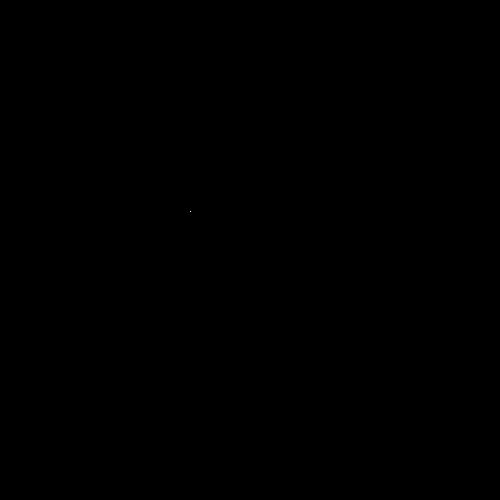

In [ ]:
hit_or_miss_item1 = np.minimum(quadro_erosao_s, quadro_erosao_ws)
hit_or_miss_item1 = Image.fromarray(hit_or_miss_item1)
hit_or_miss_item1

Segundo Objeto Vermelho

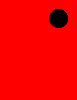

In [ ]:
obj_vermelho_1 = quadro.crop((311, 255, 388, 355))
obj_vermelho_1

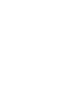

In [ ]:
obj_vermelho_2 = quadro_pb.crop((311, 255, 388, 355))
obj_vermelho_2

In [ ]:
matriz_s2 = np.array(obj_vermelho_2)
print(matriz_s2.shape)

(100, 77)


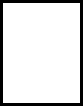

In [ ]:
w1_menos_itemverm2 = quadro_pb.crop((308, 252, 391, 358))
w1_menos_itemverm2

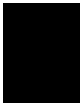

In [ ]:
w2_menos_itemverm2 = w1_menos_itemverm2.point(lambda pixel: 0 if pixel > 0 else 1, '1')
w2_menos_itemverm2

In [ ]:
matriz_ws2 = np.array(w2_menos_itemverm2)
print(matriz_ws2.shape)

(106, 83)


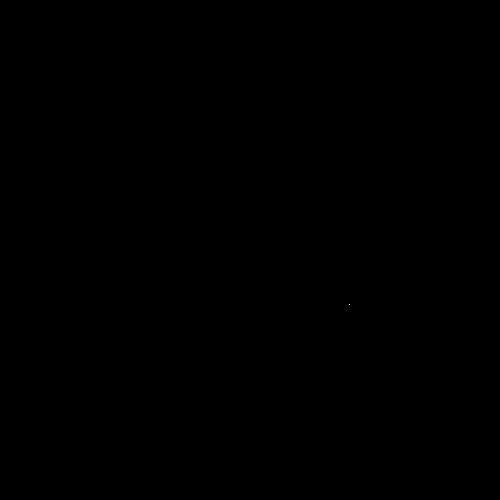

In [ ]:
quadro_erosao_s2 = morphology.erosion(quadro_pb, matriz_s2)
quadro_erosao_s2 = Image.fromarray(quadro_erosao_s2)
quadro_erosao_s2

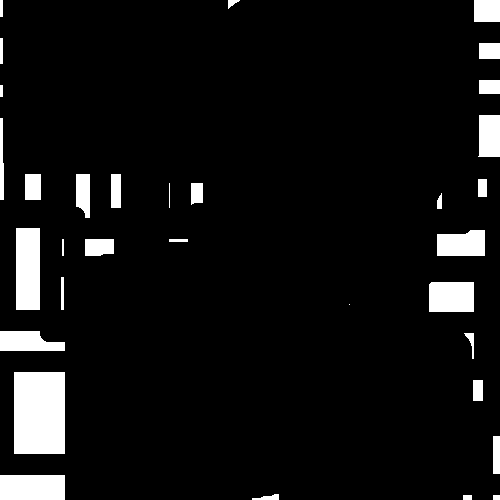

In [ ]:
quadro_erosao_ws2 = morphology.erosion(quadro_pb_comp, matriz_ws2)
quadro_erosao_ws2 = Image.fromarray(quadro_erosao_ws2)
quadro_erosao_ws2

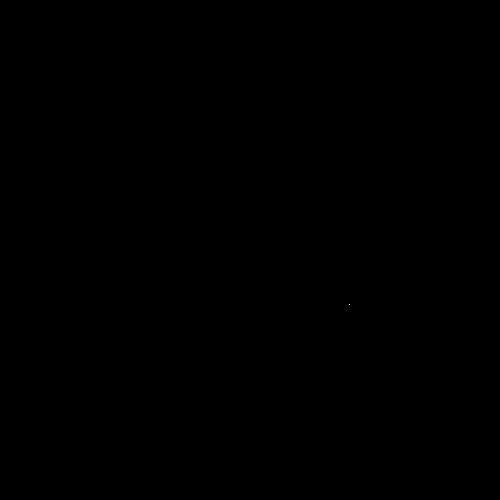

In [ ]:
hit_or_miss_item2 = np.minimum(quadro_erosao_s2, quadro_erosao_ws2)
hit_or_miss_item2 = Image.fromarray(hit_or_miss_item2)
hit_or_miss_item2

Terceiro Objeto Vermelho

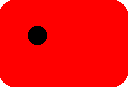

In [ ]:
obj_vermelho_3 = quadro.crop((45, 35, 173, 122))
obj_vermelho_3

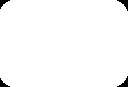

In [ ]:
obj_vermelho_3 = quadro_pb.crop((45, 35, 173, 122))
obj_vermelho_3

In [ ]:
matriz_s3 = np.array(obj_vermelho_3)
print(matriz_s3.shape)

(87, 128)


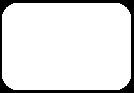

In [ ]:
w1_menos_itemverm3 = quadro_pb.crop((42, 32, 176, 125))
w1_menos_itemverm3

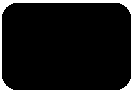

In [ ]:
w2_menos_itemverm3 = w1_menos_itemverm3.point(lambda pixel: 0 if pixel > 0 else 1, '1')
w2_menos_itemverm3

In [ ]:
matriz_ws3 = np.array(w2_menos_itemverm3)
print(matriz_ws3.shape)

(93, 134)


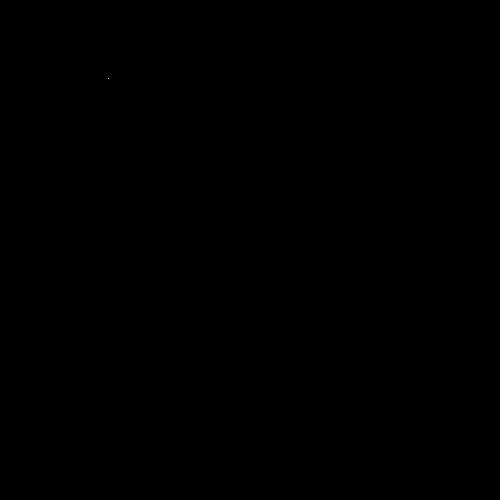

In [ ]:
quadro_erosao_s3 = morphology.erosion(quadro_pb, matriz_s3)
quadro_erosao_s3 = Image.fromarray(quadro_erosao_s3)
quadro_erosao_s3

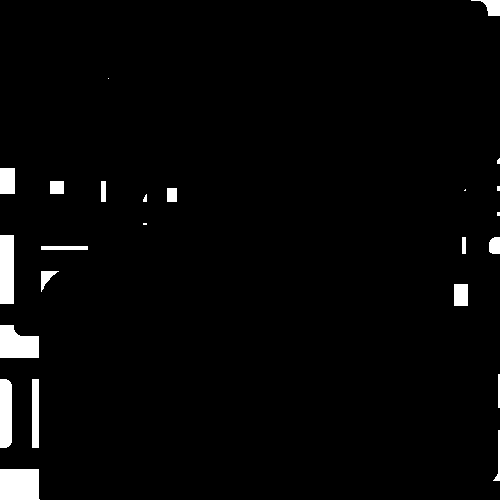

In [ ]:
quadro_erosao_ws3 = morphology.erosion(quadro_pb_comp, matriz_ws3)
quadro_erosao_ws3 = Image.fromarray(quadro_erosao_ws3)
quadro_erosao_ws3

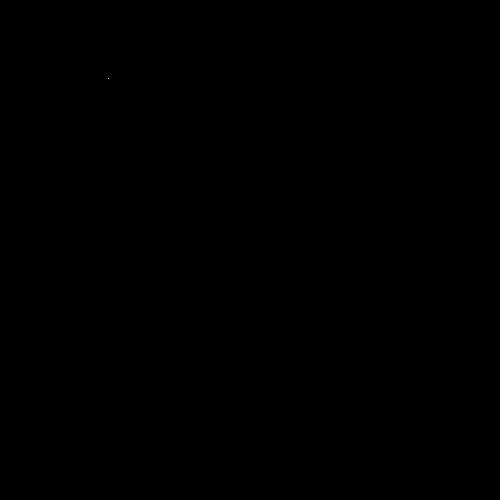

In [ ]:
hit_or_miss_item3 = np.minimum(quadro_erosao_s3, quadro_erosao_ws3)
hit_or_miss_item3 = Image.fromarray(hit_or_miss_item3)
hit_or_miss_item3

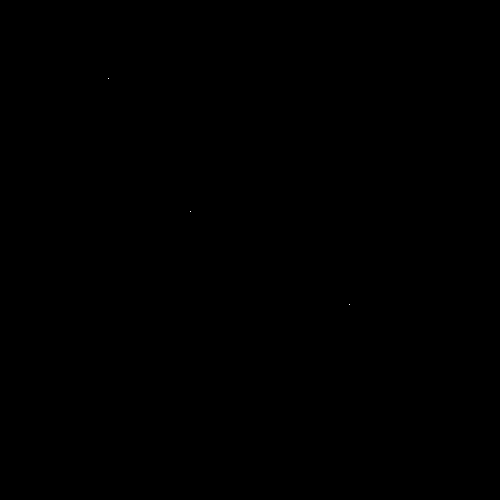

In [ ]:
objetos_vermelhos = op_morfologica(hit_or_miss_item1.convert('L'), hit_or_miss_item2.convert('L'), 0)
objetos_vermelhos = op_morfologica(objetos_vermelhos.convert('L'), hit_or_miss_item3.convert('L'), 0)
objetos_vermelhos